In [91]:
# testing
from PIL import Image

# img_path = '/home/common/chexpert_PA/patient04539/study1/view1_frontal.jpg'
img_path = '/home/jupyter-nafisha/X-ray-covariates/DX-ray-NormalVsAbnormalChexpertpatient03922study7.jpg'
# img_path = '/home/jupyter-nafisha/X-ray-covariates/d422971dcb2e5d13f06aa08656a249e8.png'
# img_path = '/home/jupyter-nafisha/X-ray-covariates/Lung Opacity, Pleural effusion, Pneumothorax-2-BB.png'       # inverted

img = Image.open(img_path).convert('RGB')

In [92]:
# pwd

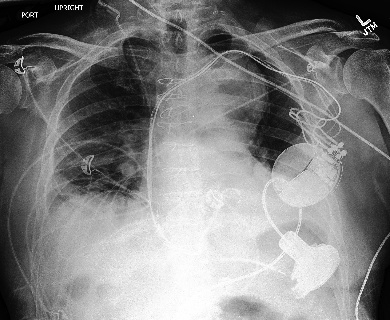

In [93]:
img

In [94]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                      std=[0.229, 0.224, 0.225])
    ])

In [95]:
transformed_img = transform(img)

In [96]:
type(img), img.size

(PIL.Image.Image, (390, 320))

In [97]:
img
transformed_img.shape, transformed_img.min(), transformed_img.max()

(torch.Size([3, 224, 224]), tensor(0.), tensor(1.))

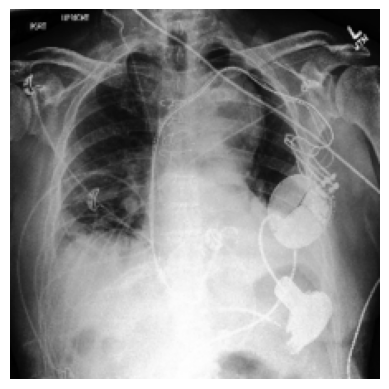

In [98]:
import matplotlib.pyplot as plt

img = transformed_img.permute(1, 2, 0).cpu().numpy()

plt.figure()
plt.imshow(img)
plt.axis("off")
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..1.9428324].


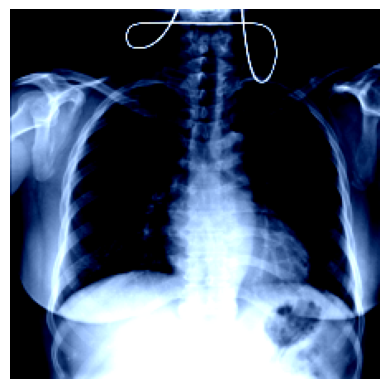

In [65]:
import matplotlib.pyplot as plt

img = transformed_img.permute(1, 2, 0).cpu().numpy()

plt.figure()
plt.imshow(img)
plt.axis("off")
plt.show()


# Testing

In [1]:
from torchvision import transforms

def get_transforms():
    return transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
        ])

In [2]:
import torch

def encode_view(frontal_lateral, ap_pa):
    # 0: PA, 1: AP, 2: Lateral
    if frontal_lateral == "lateral":
        return 2
    if ap_pa == "PA":
        return 0
    return 1

def encode_sex(sex):
    return 0 if sex == "M" else 1

In [3]:
import pandas as pd
import torch
from torch.utils.data import Dataset
from PIL import Image
import os

# from utils.transforms import get_transforms
# from utils.encoders import encode_view, encode_sex

class CXRMulitmodalDataset(Dataset):
    def __init__(self, csv_path, img_dir, transform=None):
        self.df = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.transforms = get_transforms()
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_id = row["Path"]
        img_path = os.path.join(self.img_dir, image_id)
        image = Image.open(img_path).convert("RGB")
        image = self.transforms(image)
        
        view = encode_view(row['Frontal/Lateral'], row['AP/PA'])
        sex = encode_sex(row['Sex'])
        
        view = torch.tensor(view, dtype=torch.long)
        sex = torch.tensor(sex, dtype=torch.long)
        
        label = 0 if row['label'] == 'Normal' else 1
        label = torch.tensor(label, dtype=torch.float32)
        
        return image, view, sex, label

In [4]:
import torch
import torch.nn as nn
from torchvision import models
# from config import NUM_VIEW_TYPES, NUM_SEX_TYPES

class MultimodalCNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.backbone = models.densenet121(pretrained=True)
        num_feats = self.backbone.classifier.in_features
        self.backbone.classifier = nn.Identity()
        
        
        self.view_embedding = nn.Embedding(3, 8)
        self.sex_embedding = nn.Embedding(2, 4)
        
        
        self.classifier = nn.Sequential(
            nn.Linear(num_feats + 8 + 4, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1)
        )
        
    def forward(self, image, view, sex):
        img_features = self.backbone(image)
        view_emb = self.view_embedding(view)
        sex_emb = self.sex_embedding(sex)
        
        combined = torch.cat([img_features, view_emb, sex_emb], dim=1)
        out = self.classifier(combined)
        return out

In [5]:
DEVICE= "cuda" if torch.cuda.is_available() else "cpu"
train_csv = '/home/jupyter-nafisha/X-ray-covariates/temp.csv'
img_dir = '/home/common/chexpert_PA'
train_dataset = CXRMulitmodalDataset(train_csv, img_dir, transform=get_transforms())

In [6]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)

In [7]:
train_loader

In [8]:
from torch import nn, optim

model = MultimodalCNN().to(DEVICE)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

/home/jupyter-nafisha/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jupyter-nafisha/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
model.train()
total_loss, total_correct, total_samples = 0, 0, 0

In [12]:
for image, view, sex, label in train_loader:
    image = image.to(DEVICE)
    view = view.to(DEVICE)
    sex = sex.to(DEVICE)
    label = label.float().unsqueeze(1).to(DEVICE)  # [B,1]

    # print(image.shape, view, sex, label.shape)

    optimizer.zero_grad()

    outputs = model(image, view, sex)              # [B,1] logits
    # print(outputs.shape)
    loss = criterion(outputs, label)

    loss.backward()
    optimizer.step()

    total_loss += loss.item() * label.size(0)

    preds = (torch.sigmoid(outputs) > 0.5).float()
    total_correct += (preds == label).sum().item()
    total_samples += label.size(0)
    break

# return total_loss / total_samples, total_correct / total_samples

In [13]:
outputs.shape, preds

(torch.Size([16, 1]),
 tensor([[0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.]], device='cuda:0'))

In [160]:
outputs.shape

torch.Size([16])

In [14]:
pwd

'/home/jupyter-nafisha/X-ray-covariates'

In [46]:
import shutil
# folder_path = '/home/jupyter-nafisha/chexpert_PA'
folder_path = '/home/jupyter-nafisha/Xray-Data/sub7'
shutil.make_archive(folder_path, 'zip', folder_path)

'/home/jupyter-nafisha/Xray-Data/sub7.zip'

In [47]:
import shutil
# folder_path = '/home/jupyter-nafisha/chexpert_PA'
folder_path = '/home/jupyter-nafisha/Xray-Data/sub8'
shutil.make_archive(folder_path, 'zip', folder_path)

'/home/jupyter-nafisha/Xray-Data/sub8.zip'

In [48]:
import shutil
# folder_path = '/home/jupyter-nafisha/chexpert_PA'
folder_path = '/home/jupyter-nafisha/Xray-Data/sub9'
shutil.make_archive(folder_path, 'zip', folder_path)

'/home/jupyter-nafisha/Xray-Data/sub9.zip'

In [44]:
import shutil
# folder_path = '/home/jupyter-nafisha/chexpert_PA'
folder_path = '/home/jupyter-nafisha/Xray-Data/sub5'
shutil.make_archive(folder_path, 'zip', folder_path)

'/home/jupyter-nafisha/Xray-Data/sub5.zip'

In [39]:
import os
folder_path = '/home/jupyter-nafisha/Xray-Data/sub9'
len(os.listdir(folder_path))

894

In [38]:
import os
import shutil

src_dir = '/home/jupyter-nafisha/Xray-Data'
dst_dir = '/home/jupyter-nafisha/Xray-Data/sub9'

# Create destination folder if it doesn't exist
os.makedirs(dst_dir, exist_ok=True)

# List image files (modify extensions if needed)
image_exts = ('.png', '.jpg', '.jpeg')
images = [f for f in os.listdir(src_dir) if f.lower().endswith(image_exts)]

# Take first 1000 images
images_to_move = images[:1000]

for img in images_to_move:
    src_path = os.path.join(src_dir, img)
    dst_path = os.path.join(dst_dir, img)
    shutil.move(src_path, dst_path)

print(f"Moved {len(images_to_move)} images to {dst_dir}")


Moved 894 images to /home/jupyter-nafisha/Xray-Data/sub9
